In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
import arch

In [2]:
DATA_PATH = os.path.join(os.path.abspath('../../'), 'model', 'db', 'data')
# PRIMARY_PATH = os.path.join(DATA_PATH, 'primary')
SECONDARY_PATH = os.path.join(DATA_PATH, 'secondary')

wpath = os.path.join(DATA_PATH, 'merge')

# GOAL: Garch + ARIMA combined (often best practice)
![Red: ARMA, Green: Garch](https://miro.medium.com/max/862/1*azEK9WckHXBx73L8bTPu6Q.png) Red: ARMA, Green: Garch

In [32]:
#Curency indexes dataframe for EUR currency and limited nr of rows
df = pd.read_csv(os.path.join(wpath, os.path.basename(SECONDARY_PATH), 'idxs_.csv'), parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
df = df[['EUR']][:1000]
# df = df.dropna()

Text(0.5, 1.0, '1st Order Differencing')

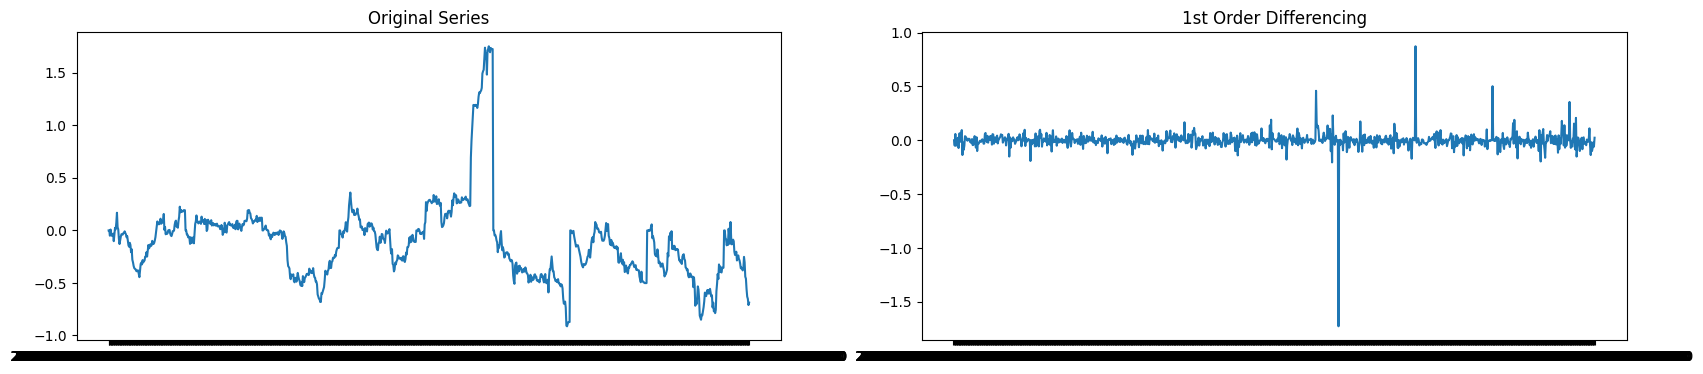

In [34]:
zero_diff = df.EUR
first_order_diff = df.EUR.diff(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


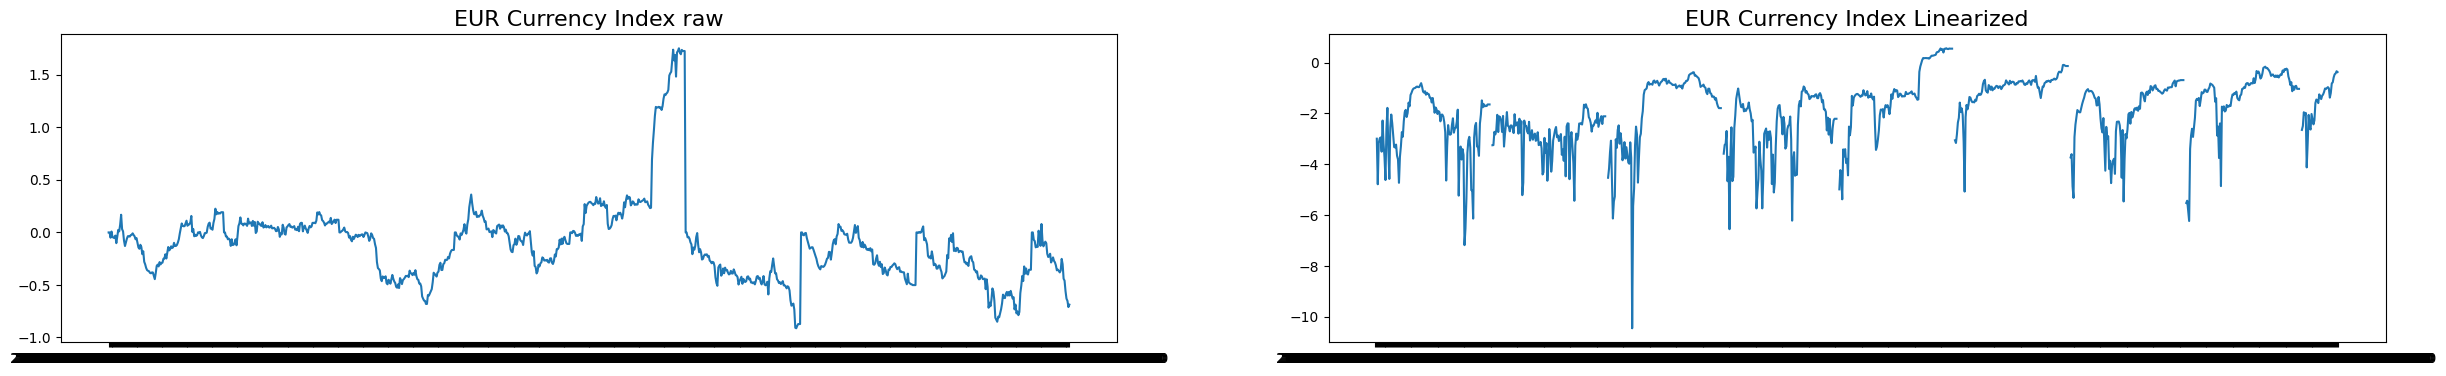

In [36]:
# Remove exponential trend for EUR
plt.figure(figsize=(30,4));

plt.subplot(1,2,1); plt.plot(df.EUR);
plt.title('EUR Currency Index raw', fontsize=16);

df['EUR_linear'] = np.log(abs(df.EUR))

plt.subplot(1,2,2); plt.plot(df['EUR_linear']);
plt.title('EUR Currency Index Linearized', fontsize=16);

In [38]:
print(df.EUR.size)
print(df.EUR_linear.size)

1000
1000


# check correlation plots

In [53]:
from statsmodels.tsa.stattools import adfuller

adfuller(df.EUR)[1]  # p-value

0.02016303435713179

In [61]:
df

,EUR,EUR_linear
2022-01-03 00:00:00+00:00,0.000000,-inf
2022-01-03 01:00:00+00:00,0.000000,-inf
2022-01-03 02:00:00+00:00,-0.050090,-2.993943
2022-01-03 03:00:00+00:00,0.008346,-4.786007
2022-01-03 04:00:00+00:00,-0.042230,-3.164617
...,...,...
2022-03-01 11:00:00+00:00,-0.559078,-0.581466
2022-03-01 12:00:00+00:00,-0.629958,-0.462102
2022-03-01 13:00:00+00:00,-0.651023,-0.429210
2022-03-01 14:00:00+00:00,-0.710560,-0.341702


In [63]:
df.loc[ df['EUR_linear']==- float('inf') ] = 0

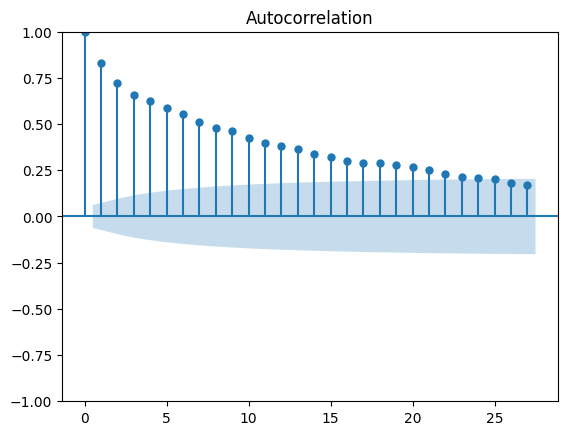

In [66]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# # tests without diff
# plot_acf(df.EUR_linear, lags=27)
# plt.show()

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


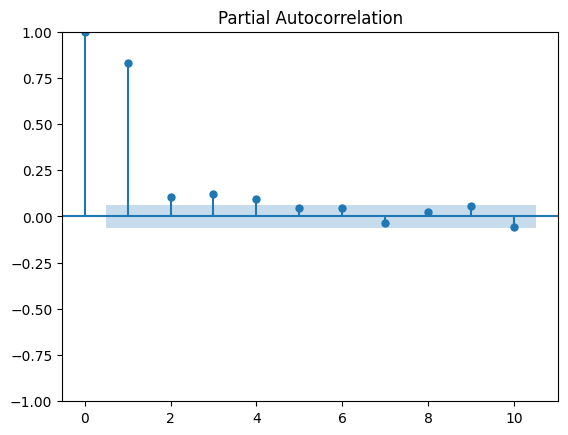

In [67]:
# # tests without diff 
# plot_pacf(df.EUR_linear, lags=10)
# plt.show()

In [72]:
# First prepare the diff linearized EUR data
y_diff = df['EUR_linear'].diff().dropna()
y_diff

2022-01-03 01:00:00+00:00    0.000000
2022-01-03 02:00:00+00:00   -2.993943
2022-01-03 03:00:00+00:00   -1.792064
2022-01-03 04:00:00+00:00    1.621390
2022-01-03 05:00:00+00:00    0.174201
                               ...   
2022-03-01 11:00:00+00:00    0.197503
2022-03-01 12:00:00+00:00    0.119364
2022-03-01 13:00:00+00:00    0.032892
2022-03-01 14:00:00+00:00    0.087508
2022-03-01 15:00:00+00:00   -0.033415
Name: EUR_linear, Length: 999, dtype: float64

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


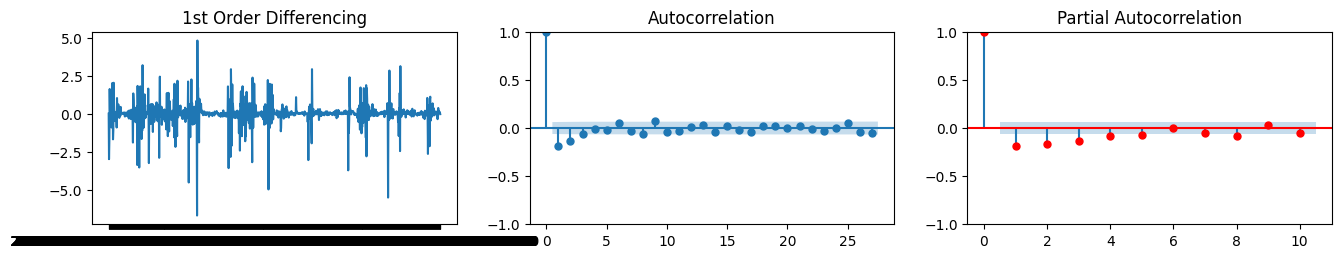

In [74]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(y_diff); axes[0].set_title('1st Order Differencing')
plot_acf(y_diff, lags=27, ax=axes[1]);
plot_pacf(y_diff, lags=10, ax=axes[2], c='r');

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


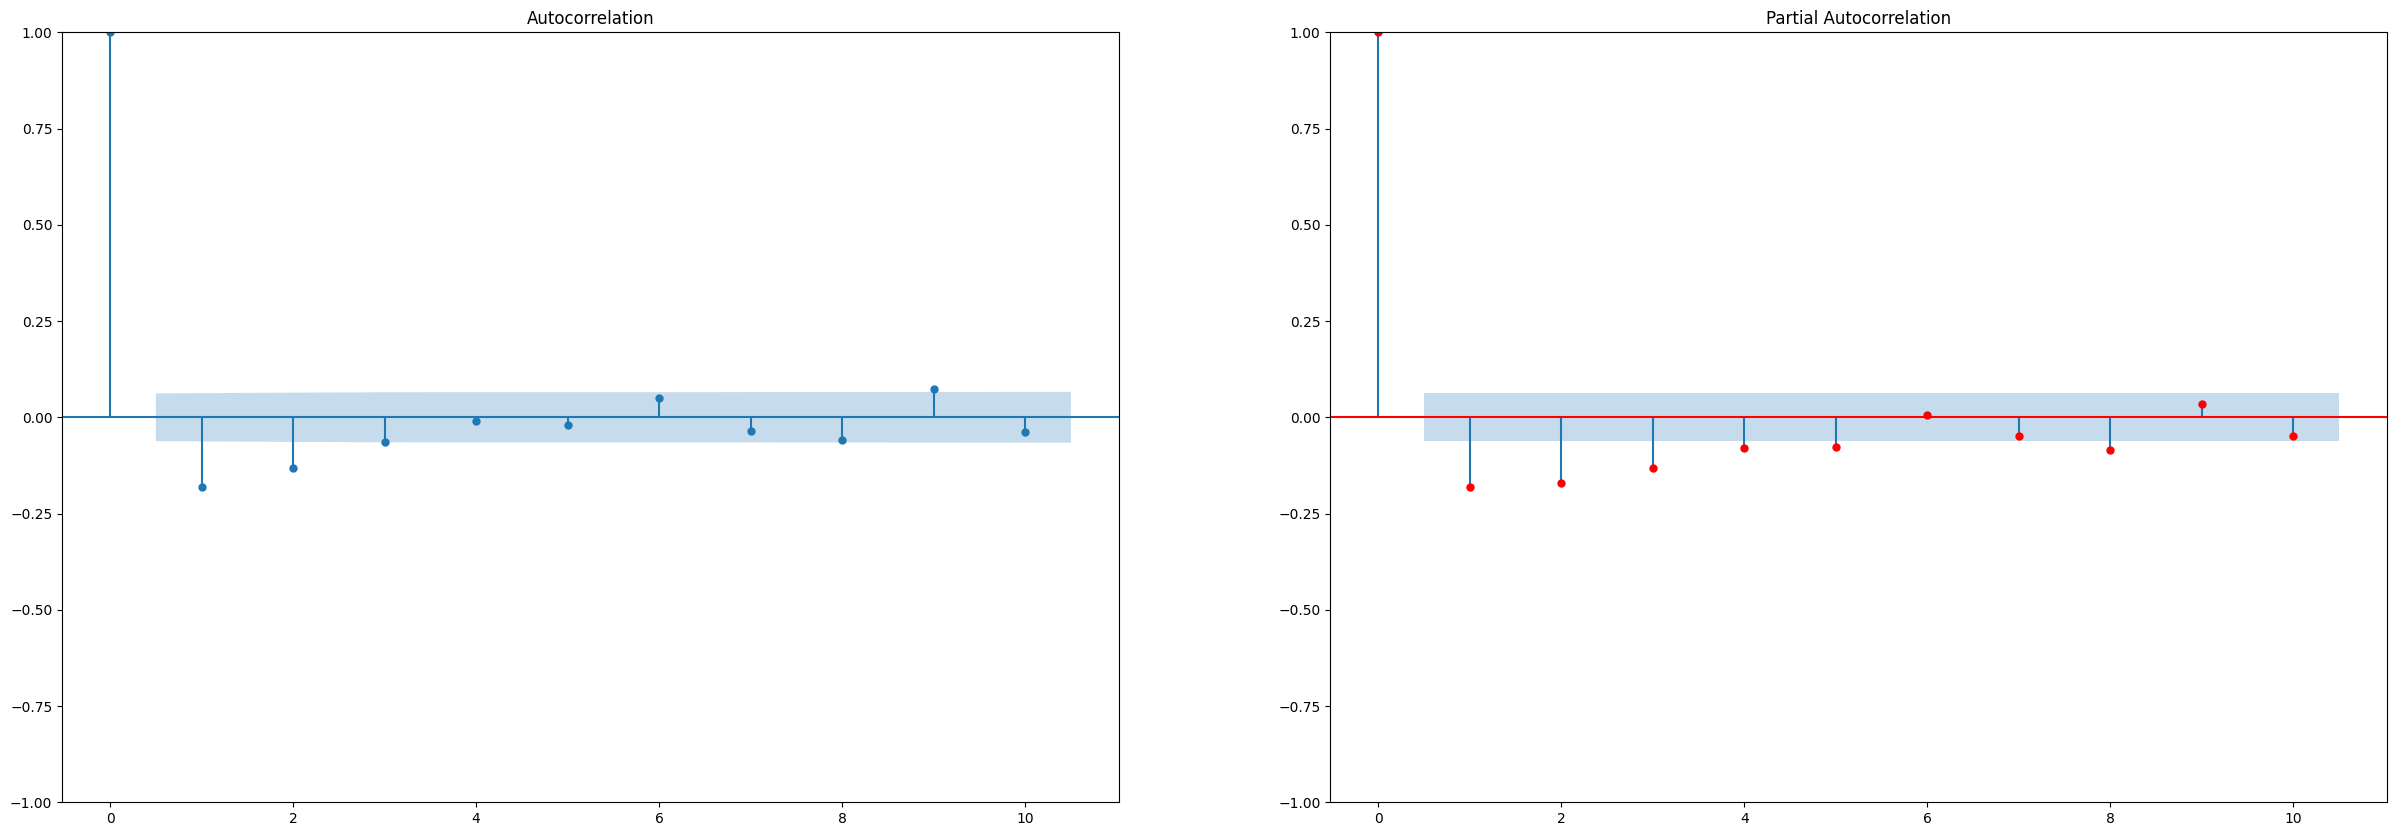

In [78]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,2, figsize=(30,10))
plot_acf(y_diff, lags=10, ax=axes[0]); # q=4
plot_pacf(y_diff, lags=10, ax=axes[1], c='r'); #p=6

In [79]:
# fit the model with PMDARIMA pakcage
model = pm.auto_arima(y_diff)

In [84]:
print(model.order)
print('---===---')
arima_residuals = model.arima_res_.resid
arima_residuals

(1, 0, 2)
---===---


2022-01-03 01:00:00+00:00    0.000000
2022-01-03 02:00:00+00:00   -2.993943
2022-01-03 03:00:00+00:00   -2.472442
2022-01-03 04:00:00+00:00    0.877090
2022-01-03 05:00:00+00:00    0.095064
                               ...   
2022-03-01 11:00:00+00:00    0.293376
2022-03-01 12:00:00+00:00    0.260950
2022-03-01 13:00:00+00:00    0.185287
2022-03-01 14:00:00+00:00    0.231811
2022-03-01 15:00:00+00:00    0.128583
Length: 999, dtype: float64

In [96]:
# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()

# Use ARIMA to predict mu
# predicted_mu = model.predict(n_periods=1)[0]
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
# prediction = predicted_mu + predicted_et

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8848.325502995562
Iteration:      2,   Func. Count:     17,   Neg. LLF: 351587.30900920834
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1039.8715550585111
Iteration:      4,   Func. Count:     29,   Neg. LLF: 3976.9529469140375
Iteration:      5,   Func. Count:     35,   Neg. LLF: 962.442638256485
Iteration:      6,   Func. Count:     41,   Neg. LLF: 915.8209409292481
Iteration:      7,   Func. Count:     46,   Neg. LLF: 915.1878930785339
Iteration:      8,   Func. Count:     51,   Neg. LLF: 914.7395523556972
Iteration:      9,   Func. Count:     56,   Neg. LLF: 914.6670589784987
Iteration:     10,   Func. Count:     61,   Neg. LLF: 914.6648917730184
Iteration:     11,   Func. Count:     66,   Neg. LLF: 914.6648556046916
Iteration:     12,   Func. Count:     71,   Neg. LLF: 914.6648551053577
Optimization terminated successfully    (Exit mode 0)
            Current function value: 914.6648551053577
            Iterations: 12

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [97]:
smodel = pm.auto_arima(y_diff,
                       start_p=1, max_p=6,
                       start_q=1, max_q=4,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2231.913, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2329.344, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2297.719, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2280.289, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2235.115, Time=0.75 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2235.226, Time=1.54 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2245.551, Time=1.87 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2269.883, Time=0.29 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2237.431, Time=0.96 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2231.913, Time=0.92 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 8.344 seconds


In [99]:
arima_residuals_s = smodel.arima_res_.resid
arima_residuals_s

2022-01-03 01:00:00+00:00    0.000010
2022-01-03 02:00:00+00:00   -2.993931
2022-01-03 03:00:00+00:00   -2.355271
2022-01-03 04:00:00+00:00    0.783367
2022-01-03 05:00:00+00:00   -0.190350
                               ...   
2022-03-01 11:00:00+00:00    0.347007
2022-03-01 12:00:00+00:00    0.304542
2022-03-01 13:00:00+00:00    0.230190
2022-03-01 14:00:00+00:00    0.274009
2022-03-01 15:00:00+00:00    0.157132
Length: 999, dtype: float64

In [98]:
# crete differentiated test data
test = df[['EUR']][2000:3000]
test['EUR_linear'] = np.log(abs(test.EUR))

y_test_diff = test['EUR_linear'].diff().dropna()

In [108]:
# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch_s = arch.arch_model(arima_residuals_s, p=1, q=1)
garch_fitted = garch_s.fit()

# Use ARIMA to predict mu
predicted_mu = smodel.predict(n_periods=1)
predicted_mu
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6162.45228934797
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1176203.0982932015
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1080.6715461340536
Iteration:      4,   Func. Count:     27,   Neg. LLF: 2472.675589444697
Iteration:      5,   Func. Count:     33,   Neg. LLF: 952.353877848418
Iteration:      6,   Func. Count:     39,   Neg. LLF: 921.1562655350136
Iteration:      7,   Func. Count:     44,   Neg. LLF: 920.9877236342322
Iteration:      8,   Func. Count:     49,   Neg. LLF: 920.8500147619347
Iteration:      9,   Func. Count:     54,   Neg. LLF: 920.8345252173958
Iteration:     10,   Func. Count:     59,   Neg. LLF: 920.8336706177422
Iteration:     11,   Func. Count:     64,   Neg. LLF: 920.8336679362737
Iteration:     12,   Func. Count:     68,   Neg. LLF: 920.8336654153725
Optimization terminated successfully    (Exit mode 0)
            Current function value: 920.8336679362737
            Iterations: 12
 

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [109]:
prediction

999   -0.11008
dtype: float64

In [ ]:
predicted_mu_1 =model1.predict(n_periods=1)[0]
predicted_mu_2 = model2.predict(n_periods=1)[0]
predicted_mu_s = smodel.predict(n_periods=1)[0]

# with statsmodels for chosen parameters from the ACF and PACF
p, d, q = 6, 1, 4

In [92]:
from statsmodels.tsa.arima.model import ARIMA  #statsmodels 0.12+

model2 = ARIMA(y_diff, order=(6, 1, 4), trend='t')
model2 = model2.fit()
# one-step out-of sample forecast
model2.summary()

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Lik

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             EUR_linear   No. Observations:                  999
Model:                 ARIMA(6, 1, 4)   Log Likelihood               -1118.869
Date:                Tue, 30 Aug 2022   AIC                           2261.739
Time:                        14:03:29   BIC                           2320.608
Sample:                             0   HQIC                          2284.115
                                - 999                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4.132e-05      0.000      0.187      0.852      -0.000       0.000
ar.L1         -1.7968      0.845     -2.127      0.033      -3.453      -0.141
ar.L2         -1.9870      0.814     -2.440      0.015      -3.583      -0.391
ar.L3         -1.4429      1.017     -1.418      0.156      -3.437       0.551
ar.L4         -0.6840      0.379     -1.804      0.071      -1.427       0.059
ar.L5         -0.4232      0.243     -1.744      0.081      -0.899       0.052
ar.L6         -0.1497      0.134     -1.115      0.265      -0.413       0.113
ma.L1          0.5808      0.846      0.686      0.493      -1.078       2.240
ma.L2         -0.0938      0.229     -0.410      0.682      -0.542       0.354
ma.L3         -0.7536      0.144     -5.235      0.000      -1.036      -0.471
ma.L4         -0.7014      0.748     -0.938      0.348      -2.168       0.765
sigma2         0.5457      0.014     40.166      0.000       0.519       0.572
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):             11353.27
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import arch

In [ ]:
# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()

# Use ARIMA to predict mu
predicted_mu = arima_model.predict(n_periods=1)[0]
# Use GARCH to predict the residual
garch_forecast = garch_model.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et